# Deep Learning and Image Recognition

https://blog.keras.io/building-autoencoders-in-keras.html

### Single fully-connected neural layer as encoder and as decoder

In [1]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

Using TensorFlow backend.


## Load Data

In [2]:
#Load MNIST dataset 
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


## Model

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [3]:
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder and decoder models:

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Train Model
Now let's train our autoencoder to reconstruct MNIST digits. 

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), verbose = 0)

## Loss curve

Text(0.5, 1.0, 'Loss Curves')

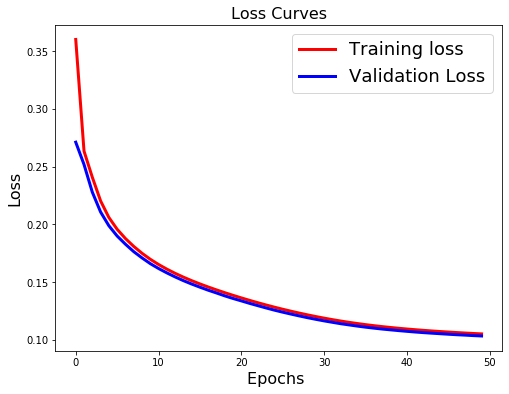

In [7]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Predict

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

print(encoded_imgs.mean())

7.218051


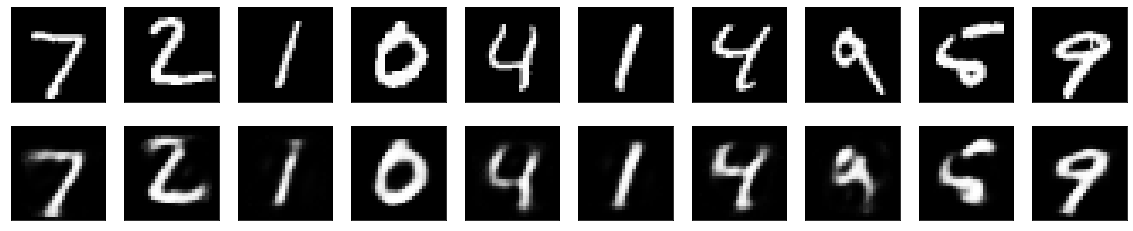

In [9]:
def plotDigits():
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plotDigits()

## Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [10]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))

# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

In [11]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), verbose = 0)

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

print(encoded_imgs.mean())

7.218051


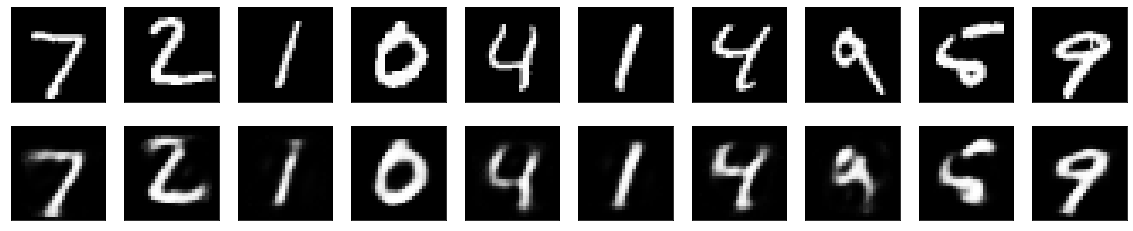

In [13]:
plotDigits()

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.